# OTNuEC

# 1) Environment

In [ ]:
ROOT <- "C:/Users/Pedro/Desktop/Dados OTNuEC"
p <- function(...) file.path(...)

DIRS <- list(
  bc250   = p(ROOT, "bc250 2025"),
  erosao  = p(ROOT, "Chance de Erosao"),
  dnit    = p(ROOT, "Dados Dnit"),
  mapbio  = p(ROOT, "Mapbiomas"),
  solos   = p(ROOT, "Qualidade do Solo"),
  rais    = p(ROOT, "RAIS"),
  etopo   = p(ROOT, "Relevo ETOPO"),
  viirs   = p(ROOT, "VIIRS"),
  sidra   = p(ROOT, "SIDRA (Faltando)")
)

# ---------------- BC250 ----------------
BC250_SHAPE <- p(DIRS$bc250, "shapefile")

bc250 <- list(
  roads   = p(BC250_SHAPE, "rod_trecho_rodoviario_l.shp"),
  rail    = p(BC250_SHAPE, "fer_trecho_ferroviario_l.shp"),
  hydro   = p(BC250_SHAPE, "hdv_trecho_hidroviario_l.shp"),
  ports   = p(BC250_SHAPE, "hdv_complexo_portuario_p.shp"),
  locks   = p(BC250_SHAPE, "hdv_eclusa_p.shp"),
  bridges = p(BC250_SHAPE, "tra_ponte_l.shp"),
  tunnels = p(BC250_SHAPE, "tra_tunel_l.shp"),
  ferries = p(BC250_SHAPE, "tra_travessia_l.shp"),
  power   = p(BC250_SHAPE, "enc_trecho_energia_l.shp"),
  hydro_p = p(BC250_SHAPE, "enc_hidreletrica_p.shp"),
  thermo  = p(BC250_SHAPE, "enc_termeletrica_p.shp"),
  subs    = p(BC250_SHAPE, "enc_subest_transm_distrib_energia_eletrica_p.shp"),
  dams    = p(BC250_SHAPE, "hid_barragem_p.shp"),
  airports= p(BC250_SHAPE, "aer_complexo_aeroportuario_p.shp")
)

# ---------------- DNIT ----------------
dnit <- DIRS$dnit

DNIT <- list(
  pav = list(
    pav = p(dnit, "Condicoes do Pavimento", "levantamentos_pavimentada_2025_10.csv"),
    nao = p(dnit, "Condicoes do Pavimento", "levantamentos_nao_pavimentada_2025_10.csv")
  ),
  od = list(
  postos   = p(dnit, "Pesquisa OD", "Postos PNT 2016-2017"),
  matrizes = p(dnit, "Pesquisa OD", "Matrizes PNT 2016-2017.xlsx"),
  micro    = p(dnit, "Pesquisa OD", "PesquisaOD 2016-2017.xlsx"),
  nota     = p(dnit, "Pesquisa OD", "NotaTécnica.pdf")
),

vmda = list(
  tabela = p(dnit, "VMDa", "VMDa 2023.xlsx"),
  nota   = p(dnit, "VMDa", "NotaTécnica VMDA 2023.pdf"),
  geo    = p(dnit, "VMDa", "(Camada Geo) VMDA - Modelagem 2023")
)
)
# ---------------- Rasters & tables ----------------
DATA <- list(
  root = ROOT,
  bc250 = bc250,
  erosao = list(raster = p(DIRS$erosao, "BR_vulnerabilidade_solos_erosao_2020.tif")),
  etopo  = list(raster = p(DIRS$etopo, "ETOPO1_Ice_g_geotiff.tif")),
  viirs  = list(blackmarble_2016 = p(DIRS$viirs, "viirs_blackmarble_br_2016.tif")),
  mapbiomas = list(forest_2024 = p(DIRS$mapbio, "brazil_coverage_2024.tif")),
  solos = list(wrb = p(DIRS$solos, "soils_brazil_wrb_wgs84.shp")),
  rais  = list(empregos = p(DIRS$rais, "consulta9293258.csv")),
  dnit  = DNIT
)


In [2]:
check_path <- function(x) {
  ok <- file.exists(x)
  if (!ok) message("FALTA: ", x)
  ok
}

check_all <- function(lst) {
  unlist(lapply(lst, function(x) {
    if (is.list(x)) check_all(x) else check_path(x)
  }))
}

check_all(DATA)


root            bc250.roads             bc250.rail 
                  TRUE                   TRUE                   TRUE 
           bc250.hydro            bc250.ports            bc250.locks 
                  TRUE                   TRUE                   TRUE 
         bc250.bridges          bc250.tunnels          bc250.ferries 
                  TRUE                   TRUE                   TRUE 
           bc250.power          bc250.hydro_p           bc250.thermo 
                  TRUE                   TRUE                   TRUE 
            bc250.subs             bc250.dams         bc250.airports 
                  TRUE                   TRUE                   TRUE 
         erosao.raster           etopo.raster viirs.blackmarble_2016 
                  TRUE                   TRUE                   TRUE 
 mapbiomas.forest_2024              solos.wrb          rais.empregos 
                  TRUE                   TRUE                   TRUE 
          dnit.pav.pav           dnit.pav.nao         dnit.od.postos 
                  TRUE                   TRUE                   TRUE 
      dnit.od.matrizes          dnit.od.micro           dnit.od.nota 
                  TRUE                   TRUE                   TRUE 
      dnit.vmda.tabela         dnit.vmda.nota          dnit.vmda.geo 
                  TRUE                   TRUE                   TRUE

In [3]:
library(sf)
library(geobr)
library(terra)
library(dplyr)


Warning message:
"pacote 'sf' foi compilado no R versão 4.5.2"
Linking to GEOS 3.13.1, GDAL 3.11.4, PROJ 9.7.0; sf_use_s2() is TRUE

Warning message:
"pacote 'geobr' foi compilado no R versão 4.5.2"
Warning message:
"pacote 'terra' foi compilado no R versão 4.5.2"
terra 1.8.80


Anexando pacote: 'dplyr'


Os seguintes objetos são mascarados por 'package:terra':

    intersect, union


Os seguintes objetos são mascarados por 'package:stats':

    filter, lag


Os seguintes objetos são mascarados por 'package:base':

    intersect, setdiff, setequal, union




In [4]:
AUX <- file.path(DATA$root, "aux_data")
dir.create(AUX, showWarnings = FALSE, recursive = TRUE)
NODES_FILE <- file.path(AUX, "nodes_micro_viirs.gpkg")


# 2) Data Display

## 2.1) Nodes Position

In [5]:
# Brasil continental (aprox.)
clip_mainland_ll <- function(x) {
sf::st_crop(
x,
xmin = -75, # oeste
xmax = -34, # leste (corta Fernando de Noronha, ~ -32.4)
ymin = -35, # sul
ymax = 6 # norte
)
}
micro_br <- geobr::read_micro_region(
year = 2013,
simplified = TRUE
) |>
clip_mainland_ll()

Using year/date 2013

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


In [6]:
if (file.exists(NODES_FILE)) {

  message("→ carregando nodes_micro do disco")
  nodes_micro <- st_read(NODES_FILE, quiet = TRUE)

} else {
# ------------------------------------------------------------
# 1) Ler raster VIIRS
# ------------------------------------------------------------
ntl <- terra::rast(DATA$viirs$blackmarble_2016)
names(ntl) <- "value"
# ------------------------------------------------------------
# 2) Função minimalista: ponto mais iluminado por microrregião
# ------------------------------------------------------------
build_nodes_simple <- function(regions_sf, ntl_rast) {
# garantir mesmo CRS
regions_ll <- st_transform(regions_sf, st_crs(ntl_rast))
# extrair valores do raster dentro de cada polígono
vals <- terra::extract(ntl_rast, terra::vect(regions_ll), cells = TRUE)
best <- vals |>
dplyr::group_by(ID) |>
dplyr::filter(!is.na(value)) |>
dplyr::slice_max(order_by = value, n = 1, with_ties = FALSE) |>
dplyr::ungroup()
xy <- terra::xyFromCell(ntl_rast, best$cell)
sf::st_as_sf(
data.frame(
id = regions_ll$code_micro[best$ID],
lon = xy[,1],
lat = xy[,2]
),
coords = c("lon", "lat"),
crs = st_crs(ntl_rast)
)
}
# ------------------------------------------------------------
# 3) Construir os nós
# ------------------------------------------------------------
nodes_micro <- build_nodes_simple(micro_br, ntl)
st_write(
  nodes_micro,
  NODES_FILE,
  delete_dsn = TRUE
)
}

→ carregando nodes_micro do disco



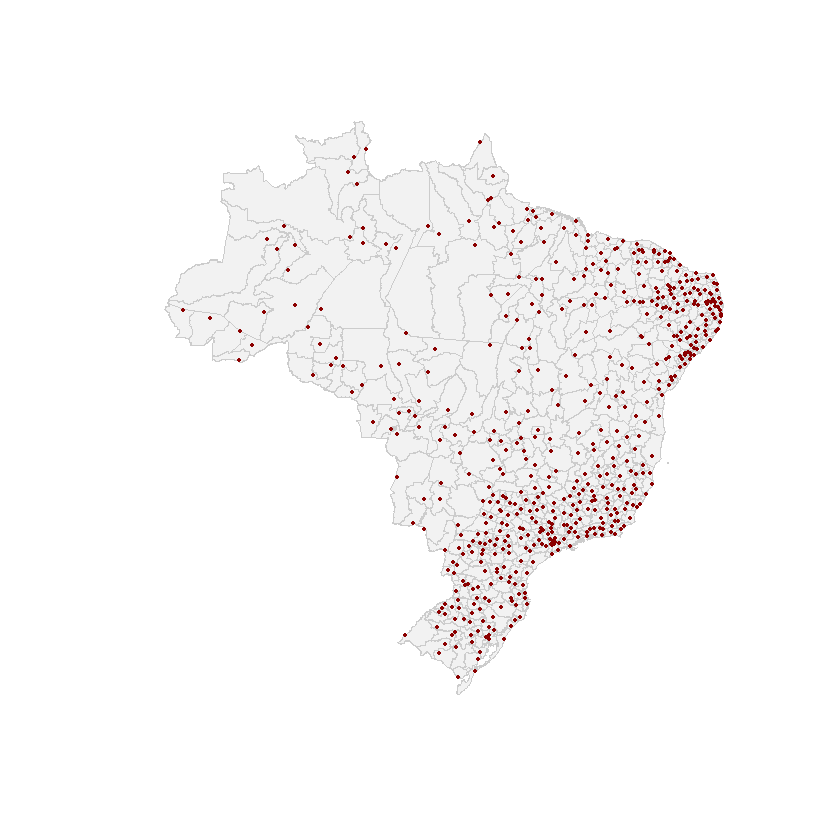

In [7]:
plot(
  st_geometry(micro_br),
  col = "grey95",
  border = "grey80",
  lwd = 0.5
)

plot(
  st_geometry(nodes_micro),
  add = TRUE,
  pch = 20,
  col = "darkred",
  cex = 0.7
)


# 2.2) Protected Areas

In [8]:
PA_FILE <- file.path(DATA$root, "aux_data", "pa_uc_ti.rds")

if (file.exists(PA_FILE)) {
  pa_uc_ti <- readRDS(PA_FILE)
} else {
  dir.create(file.path(DATA$root, "aux_data"), showWarnings = FALSE, recursive = TRUE)

  pa_uc_ti <- bind_rows(
    geobr::read_conservation_units() |> mutate(src = "UC"),
    geobr::read_indigenous_land()     |> mutate(src = "TI")
  ) |>
    st_make_valid()
  br_mainland <- geobr::read_state(year = 2020) |>
  st_union() |>
  st_make_valid()

  pa_uc_ti <- st_intersection(pa_uc_ti, br_mainland)
  saveRDS(pa_uc_ti, PA_FILE)
}

Warning message:
"pacote 'ggplot2' foi compilado no R versão 4.5.2"


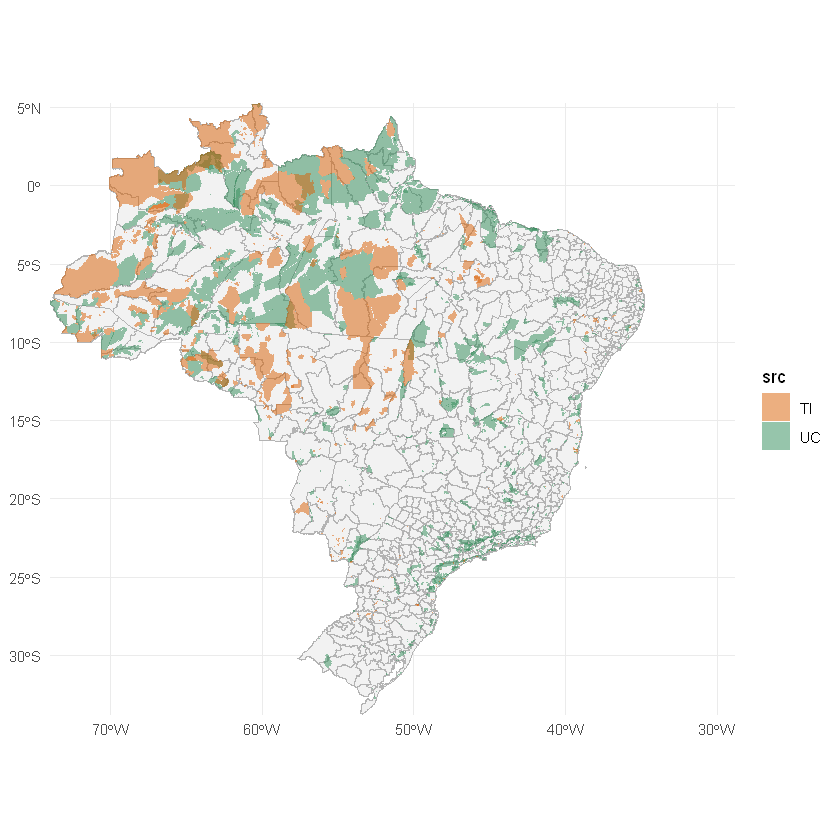

In [9]:
# se micro_br ainda nao existe:
# micro_br <- geobr::read_micro_region(year = 2020)

library(ggplot2)

ggplot() +
  geom_sf(data = micro_br, fill = "grey95", color = "grey70", size = 0.1) +
  geom_sf(data = pa_uc_ti, aes(fill = src), color = NA, alpha = 0.5) +
  scale_fill_manual(values = c(UC = "#2E8B57", TI = "#D95F02")) +
  coord_sf(expand = FALSE) +
  theme_minimal() +
  theme(legend.position = "right")
